In [2]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
)
from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-03-22 15:47:24.383490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:47:24.535137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-03-22 15:47:24.535165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [3]:
plates = ["1045_20220504", "1048_20220506", "52_20220707"]
directory_targ = directory_project
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/3345 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
folders = all_folders.loc[all_folders["unique_id"] == "52_20220707"]
folders = folders.sort_values(by="datetime")
folders = folders.iloc[0:42]

exp = Experiment(directory_targ)
exp.load(folders)
exp.dates.sort()
for t in range(len(folders)):
    exp.load_tile_information(t)

NameError: name 'all_folders' is not defined

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


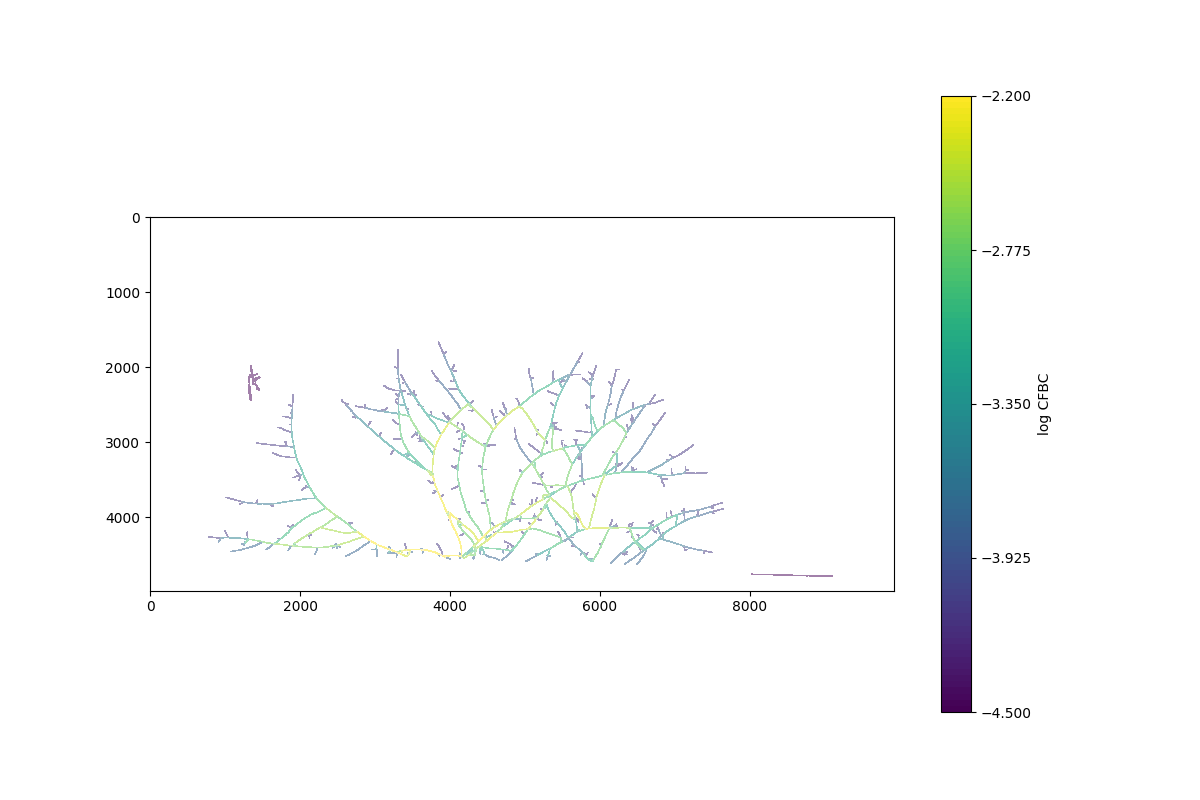

In [12]:
plt.close("all")
vmax = -2.2
vmin = -4.5
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.current_flow_betweeness(t)),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=20,
    figsize=(12, 8),
    label_colorbar="log CFBC",
)
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

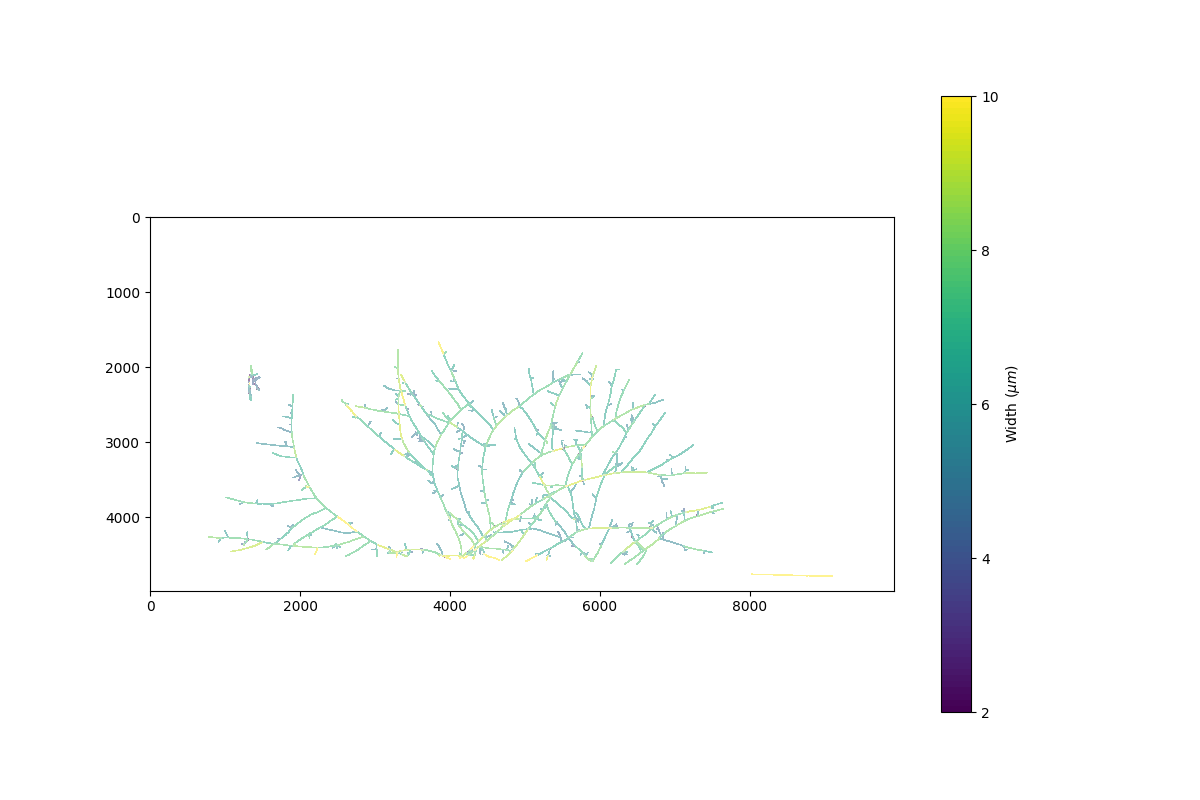

<AxesSubplot:>

In [13]:
vmax = 10
vmin = 2
plot_edge_color_value(
    exp,
    t,
    lambda edge: edge.width(t),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=20,
    figsize=(12, 8),
)
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'width.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)